### shortcuts 

0,0 : restart the kernel (with dialog)
A : insert cell above
B : insert cell below
L : show line-numbers
space : scroll down
space + shift : scroll up
shift + enter: run selected

# Kontradiktoriska Exempel


All cred and internal glory to https://github.com/Hvass-Labs/TensorFlow-Tutorials for the **interception V3** class and amazing youtube channel!

DISCLAIMER:
We have added a new **loss-function** to the graph, that calculates the so-called cross-entropy, which is a measure of how well the Inception model has performed at classifying the noisy image. This operates on the entire ouput state of the model which is far superiror to only using 5 best classes (Black-box Adversarial Attacks with Limited Queries and Information by Andrew Ilyas, Logan Engstrom, Anish Athalye, Jessy Lin https://arxiv.org/abs/1804.08598)

Because the Inception model is constructed from many basic mathematical operations that have been combined, TensorFlow allows us to easily find the gradient of the loss-function using the chain-rule of differentiation. We use the gradient of the loss-function with regard to the input-image, to guide us when searching for the adversarial noise. We are looking for noise that increases the classification score (aka. probability) for 'target_class'.

We get a reference to the input tensor for the Inception model. This tensor is for the resized image, that is, the raw bytes for a 299 x 299 image with 3 colour channels. We will add noise to the resized image and feed the result back into the graph using this as well, so we make sure that the noise **is not processed further by the resizing algorithm**. Then essentially perform optimization using gradient descent and is implemented further below.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import inception

from PIL import Image
import boto3
import os 

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version: 1.10.0

In [2]:
tf.__version__

'1.10.0'

## Inception Model (Hvass-Labs/TensorFlow-Tutorials)

In [3]:
inception.data_dir = 'inception/'
inception.maybe_download()
model = inception.Inception()

Data has apparently already been downloaded and unpacked.


In [4]:
#inspect classes
def print_classes(first):
    if first > 1000:
        first = 1000
    cls = lambda input : inception.NameLookup().cls_to_name(input)
    for i in range(1,first+1):
        print(i, cls(i))
#print_classes(10)

In [5]:
#store references that are needed later.
resized_image = model.resized_image
y_pred = model.y_pred
y_logits = model.y_logits

### Hack the Inception Model (G basically)

In [6]:
# Set the graph for the Inception model as the default graph,
with model.graph.as_default():
    pl_cls_target = tf.placeholder(dtype=tf.int32)
    # Add a new loss-function. This is the cross-entropy.
    new_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target])
    # Get the gradient for the loss-function with regard to the resized input image.
    gradient = tf.gradients(new_loss, resized_image)

### TensorFlow Session

In [7]:
session = tf.Session(graph=model.graph)

### Helper functions

In [8]:
def find_adversary_noise(image_path, cls_target, noise_limit=3.0,
                         required_score=0.99, max_iterations=100):
    """
    finds the noise that must be added to the given input image so as to be classified as the desired target-class.
    image_path: File-path to the input .jpg image
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Upper-Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    max_iterations: Max number of optimization iterations to perform.
    """
    
    def predict_input(image_path, cls_target):
        #feed_dict is basically stream filling model with values in TF
        aFeed_dict = model._create_feed_dict(image_path=image_path)

        #predict class-score (aka. probabilities) & resized image in TF
        pred, image = session.run([y_pred, resized_image], feed_dict=aFeed_dict)
        pred = np.squeeze(pred)
        cls_source = np.argmax(pred)

        # Score for the predicted class (aka. probability or confidence).
        score_source_org = pred.max()

        # Names for the source and target classes.
        name_source = model.name_lookup.cls_to_name(cls_source, only_first_name=True)
        name_target = model.name_lookup.cls_to_name(cls_target, only_first_name=True)
        return name_source, name_target, image, cls_source, score_source_org

    name_source, name_target, image, cls_source, score_source_org = predict_input(image_path, cls_target)
    
    # Initialize the noise to zero.
    noise = 0

    # Perform optimization iterations to find adveserial noise
    for i in range(max_iterations):
        print("Iteration:", i)

        noisy_image = image + noise
        # Ensure the pixel-values of the noisy image are between 0 and 255 like a real image
        noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=255.0)

        # Create a feed-dict. noisy image -> tensor in the graph that holds the resized image + target class-number
        feed_dict = {model.tensor_name_resized_image: noisy_image, pl_cls_target: cls_target}

        # compute grad and scores
        pred, grad = session.run([y_pred, gradient], feed_dict=feed_dict)
        pred = np.squeeze(pred)
        score_source = pred[cls_source]
        score_target = pred[cls_target]

        # Squeeze the dimensionality for the gradient-array.
        grad = np.array(grad).squeeze()

        #max of the absolute gradient values = step-size.
        grad_absmax = np.abs(grad).max()
        
        # If the gradient is very small then use a lower limit, we divide by this below!
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10

        #step-size was found to give fast convergence by https://github.com/Hvass-Labs/TensorFlow-Tutorials
        step_size = 7 / grad_absmax

        def printScores():
            # Print the score etc. for the source-class.
            msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
            print(msg.format(score_source, cls_source, name_source))

            # Print the score etc. for the target-class.
            msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
            print(msg.format(score_target, cls_target, name_target))

            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size))

            # Newline.
            print()
        printScores()

        # next step or abort?
        if score_target < required_score:
            # image-noise = image-noise - gradient * scaled by the step-size.
            noise -= step_size * grad

            # noise is within noise_limit.avoid distorting the image
            noise = np.clip(a=noise, a_min=-noise_limit, a_max=noise_limit)
        else:
            break

    return image.squeeze(), noisy_image.squeeze(), noise, \
           name_source, name_target, \
           score_source, score_source_org, score_target

In [9]:
def normalize_image(x):
    """
    normalizes to between 0.0 and 1.0.
    """
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [10]:
def plot_images(image, noise, noisy_image,
                name_source, name_target,
                score_source, score_source_org, score_target):
    """
    Plot the image, the noisy image and the noise, shows the class-names and scores.
    noise is amplified to use the full range of colours, otherwise it would be hard to see.

    image: Original input image.
    noise: Noise that has been added to the image.
    noisy_image: Input image + noise.
    name_source: Name of the source-class.
    name_target: Name of the target-class.
    score_source: Score for the source-class.
    score_source_org: Original score for the source-class.
    score_target: Score for the target-class.
    """
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Plot the original image.
    # Note that the pixel-values are normalized to the [0.0, 1.0]
    # range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    # Plot the noisy image.
    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    # Plot the noise.
    # The colours are amplified otherwise they would be hard to see.
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    plt.savefig("output/latest_joined_fig.png")

In [11]:
def adversary_example(image_path, cls_target,
                      noise_limit, required_score):
    """
    Find & plot adversarial noise for the given image.    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    """

    # Find the adversarial noise.
    image, noisy_image, noise, \
    name_source, name_target, \
    score_source, score_source_org, score_target = \
        find_adversary_noise(image_path=image_path,
                             cls_target=cls_target,
                             noise_limit=noise_limit,
                             required_score=required_score)

    # Plot the image and the noise.
    plot_images(image=image, noise=noise, noisy_image=noisy_image,
                name_source=name_source, name_target=name_target,
                score_source=score_source,
                score_source_org=score_source_org,
                score_target=score_target)

    # Print some statistics for the noise.
    msg = "Noise min: {0:.3f}, max: {1:.3f}, mean: {2:.3f}, std: {3:.3f}"
    print(msg.format(noise.min(), noise.max(),
                     noise.mean(), noise.std()))
    
    return noisy_image


def adversary_example_dont_return_image(image_path, cls_target,
                      noise_limit, required_score):
    adversary_example(image_path, cls_target,
                      noise_limit, required_score)

    

In [12]:
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket("gustavsandstromadversarialexamples").put_object(Key=key, Body=data)

def save_and_upload_to_s3_and_delete(noisy_image, name):
    file_path = "output/" + name +".png"
    im = Image.fromarray(noisy_image.astype('uint8'))
    im.save(file_path, format='PNG')
    upload_to_s3('keras.js', file_path)
    os.remove(file_path)
    
def save_and_upload_to_s3_and_delete_less_compression(noisy_image, name):
    file_path = "output/" + name +".png"
    im = Image.fromarray(noisy_image.astype('uint8'))
    im.save(file_path, format='PNG', subsampling=0, quality=100)
    upload_to_s3('keras.js', file_path)
    os.remove(file_path)

# Experiment

Iteration: 0
Source score:  99.94%, class-number:  323, class-name: banana
Target score:   0.00%, class-number:  885, class-name: hotdog
Gradient min: -0.009724, max:  0.009189, stepsize:    719.85

Iteration: 1
Source score:   3.78%, class-number:  323, class-name: banana
Target score:   0.03%, class-number:  885, class-name: hotdog
Gradient min: -0.005763, max:  0.008517, stepsize:    821.87

Iteration: 2
Source score:   8.35%, class-number:  323, class-name: banana
Target score:   0.14%, class-number:  885, class-name: hotdog
Gradient min: -0.007886, max:  0.007986, stepsize:    876.52

Iteration: 3
Source score:   0.14%, class-number:  323, class-name: banana
Target score:   0.10%, class-number:  885, class-name: hotdog
Gradient min: -0.009498, max:  0.010672, stepsize:    655.95

Iteration: 4
Source score:   0.82%, class-number:  323, class-name: banana
Target score:   0.30%, class-number:  885, class-name: hotdog
Gradient min: -0.006402, max:  0.007627, stepsize:    917.76

Itera

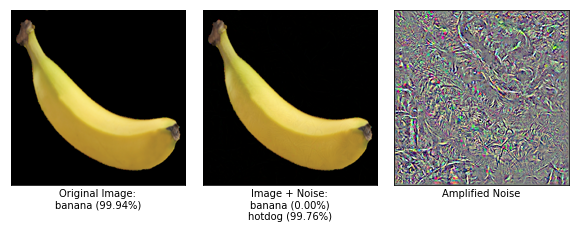

Noise min: -3.000, max: 3.000, mean: -0.028, std: 1.122


<Figure size 432x288 with 0 Axes>

In [14]:
adversary_example_dont_return_image(image_path='data/banana.png',
                  cls_target=885,
                  noise_limit=3.0,
                  required_score=0.99)

# Experiment2

Iteration: 0
Source score:  94.57%, class-number:  961, class-name: jersey
Target score:   0.00%, class-number:  851, class-name: broom
Gradient min: -0.005464, max:  0.004475, stepsize:   1281.14

Iteration: 1
Source score:  23.19%, class-number:  961, class-name: jersey
Target score:   0.05%, class-number:  851, class-name: broom
Gradient min: -0.002491, max:  0.002631, stepsize:   2660.92

Iteration: 2
Source score:  21.23%, class-number:  961, class-name: jersey
Target score:   0.11%, class-number:  851, class-name: broom
Gradient min: -0.003080, max:  0.003971, stepsize:   1762.71

Iteration: 3
Source score:   1.20%, class-number:  961, class-name: jersey
Target score:   0.46%, class-number:  851, class-name: broom
Gradient min: -0.003655, max:  0.003794, stepsize:   1845.24

Iteration: 4
Source score:  23.58%, class-number:  961, class-name: jersey
Target score:   1.00%, class-number:  851, class-name: broom
Gradient min: -0.006129, max:  0.007912, stepsize:    884.70

Iteration:

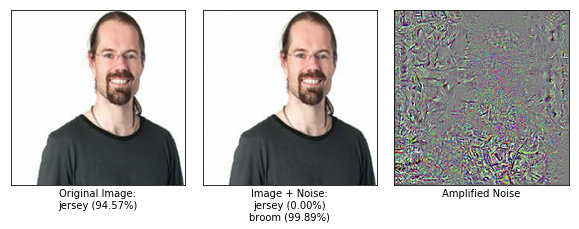

Noise min: -3.000, max: 3.000, mean: 0.003, std: 0.828


<Figure size 432x288 with 0 Axes>

In [15]:
noisy_image = adversary_example(image_path="data/dbj.jpeg",
                  cls_target=851,
                  noise_limit=3.0,
                  required_score=0.99)

save_and_upload_to_s3_and_delete(noisy_image, "opkoko_1")

Iteration: 0
Source score:  94.57%, class-number:  961, class-name: jersey
Target score:   0.00%, class-number:  851, class-name: broom
Gradient min: -0.005464, max:  0.004475, stepsize:   1281.14

Iteration: 1
Source score:  22.36%, class-number:  961, class-name: jersey
Target score:   0.05%, class-number:  851, class-name: broom
Gradient min: -0.007042, max:  0.003190, stepsize:    993.97

Iteration: 2
Source score:  12.97%, class-number:  961, class-name: jersey
Target score:   0.13%, class-number:  851, class-name: broom
Gradient min: -0.003301, max:  0.004045, stepsize:   1730.51

Iteration: 3
Source score:   4.03%, class-number:  961, class-name: jersey
Target score:   0.37%, class-number:  851, class-name: broom
Gradient min: -0.004757, max:  0.004130, stepsize:   1471.64

Iteration: 4
Source score:  14.90%, class-number:  961, class-name: jersey
Target score:   1.54%, class-number:  851, class-name: broom
Gradient min: -0.007236, max:  0.009645, stepsize:    725.79

Iteration:

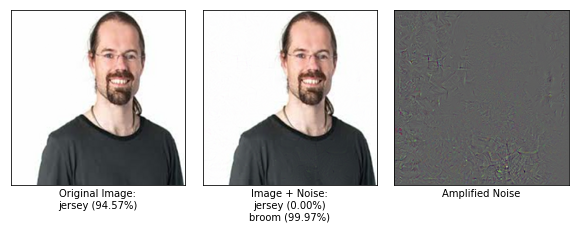

Noise min: -13.305, max: 22.312, mean: -0.000, std: 0.808


<Figure size 432x288 with 0 Axes>

In [16]:
noisy_image = adversary_example(image_path="data/dbj.jpeg",
                  cls_target=851,
                  noise_limit=30.0,
                  required_score=0.999)

save_and_upload_to_s3_and_delete_less_compression(noisy_image, "opkoko2")

## Close TensorFlow Session

In [ ]:
#session.close()
#model.close()

<img src="data/sleep.jpg">